# EDA Maze
source: https://samyzaf.com/ML/rl/qmaze.html

![SegmentLocal](20190526_1740_gif_GOOD_UNTIL_END/seq_movie.gif "segment")

In [84]:
import numpy as np
import os
import random
import datetime
import sys
import json


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

In [4]:
def show(qmaze, cmap_input='gray'):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap=cmap_input)
    return img

In [5]:
class Qmaze(object):
    """
    Class Description 
    ------------------
    
    free_cell == 1.0
    wall_cell == 0.0
    
    _maze: original maze - not altered - only walls + free cells
    maze:  maze + way of rat - colored where rat went through, and is now
    
    functions: 
    def reset(rat):
    def update_state(action):
    def valid_actions():
        
        
    """
    def __init__(self, maze, rat=(0,0)):
        self._maze_original = np.array(maze)
        nrows, ncols = self._maze_original.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        # TODO: position of "cheese" can be chosen freely (on a free_cell) // free_cell == 1.0
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze_original[r,c] == 1.0]
        # the "cheese"=target is not a free_cell - remove
        self.free_cells.remove(self.target)
        # check: cheese(=target) can't be a wall(=0.0)
        if self._maze_original[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)
        
    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze_original)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark  # rat_mark: outside variable for coloring rat's way
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size   # row * col
        self.total_reward = 0
        self.visited = set()  # reset visited cells (it's a set)
        
    def update_state(self, action):
        """
        Based on Action, udpate rat's position
        
        also being done:
        - mark visited cell
        - checks valid movements/actions
        """
        
        nrows, ncols = self.maze.shape
        # before action - where is the rat:
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:  # if rat is in free cell (before action)
            self.visited.add((rat_row, rat_col))  # mark visited cell (before action)
            # print('visited cell/current cell=', self.visited)  # temp

        # to where can rat move?
        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'   # no where to go
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            nmode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        
        
    def valid_actions(self, cell=None):
        """
        Check where rat is
        Check where rat can go
        
        return: possible actions - but rat has NOT YET moved
        """
        if cell is None:  # current cell rat is in
            row, col, mode = self.state
        else:  # special cell to be checked
            row, col = cell
            
        actions = [0, 1, 2, 3]
        # 0: LEFT
        # 1: UP
        # 2: RIGHT
        # 3: DOWN
        nrows, ncols = self.maze.shape
        if row == 0:  # top row
            actions.remove(1)
        elif row == nrows-1:  # bottom row
            actions.remove(3)

        if col == 0:  # most left col
            actions.remove(0)
        elif col == ncols-1:  # most right col
            actions.remove(2)
        # if cell above is a wall - remove UP:
        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        # if cell below is a wall - remove DOWN:
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)
        # if cell to the left is a wall - remove LEFT
        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        # if cell to the right is a wall - remove RIGHT:
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)
        # print('possible actions before acting=', actions)  # temp
        return actions
    
    def get_reward(self):
        """
        returns:
            1     - rat found cheese
            -33   - mode==blocked ((-0.5 * 8 * 8) - 1 <-- example maze 8*8)
                                  (self.min_reward = -0.5 * self.maze.size)
            -0.25 - cell already visited
            -0.75 - mode==invalid (no change in position)
            -0.04 - mode==valid
        """
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        
        # rat found cheese
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0 
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04
        
    def game_status(self):
        """
        Example: maze 8*8
            min_reward = -0.5 * self.maze.size = -32
        Example: maze 3*3
            min_reward = .... = -4.5
        """
        # rat cant run indefinitely around the maze:
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        # rat found cheese:
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'
    
    def draw_env(self):
        """
        Clears path of rat
        Draws only rat position
        """
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        # mmor: is this not equal the original _maze ?
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    
    def observe(self):
        canvas = self.draw_env()  # draws only maze and rat (clears path of rat)
        envstate = canvas.reshape((1, -1))
        return envstate  # envstate is only: original maze + rat position

    
    def act(self, action):
        """
        input: action
        output:
            envstate: flattened maze + rat (without rat's path)
            reward: reward of this particular move
            status: new game status (3 possibilities: lose, win, not_over)
        """
        self.update_state(action)  # returns new state: self.state = (nrow of rat, ncol of rat, nmode)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()  # checks total_reward or cheese_found // returns status
        envstate = self.observe()
        return envstate, reward, status

In [6]:
maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]

In [7]:
qmaze = Qmaze(maze)

print('current maze with rat\n')
qmaze.maze

current maze with rat



array([[0.5, 0. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0. , 1. , 1. , 1. , 0. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 0. , 1. , 0. , 1. ],
       [1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 0. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 0. , 1. , 0. , 0. , 0. ],
       [1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. ]])

In [8]:
canvas, reward, game_over = qmaze.act(DOWN)  # move down
print('canvas=\n', canvas)
print('reward=', reward)
print('game_over=', game_over)

canvas=
 [[1.  0.  1.  1.  1.  1.  1.  1.  0.5 0.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  1.  1. ]]
reward= -0.04
game_over= not_over


In [9]:
qmaze.state

(1, 0, 'valid')

reward= -0.04
total_reward=-0.08 out of -32.0
state= (2, 0, 'valid')
visited= {(1, 0), (0, 0)}


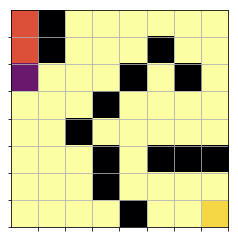

In [10]:
# qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
print('total_reward={a} out of {b}'.format(a=qmaze.total_reward, b=qmaze.min_reward))
print('state=', qmaze.state)
print('visited=', qmaze.visited)
show(qmaze, cmap_input='inferno');

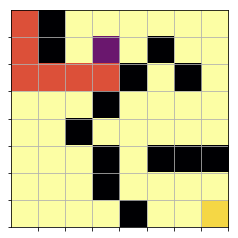

In [11]:
qmaze.reset(rat=(0,0))
qmaze.act(DOWN)  # move down
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze, cmap_input='inferno');

Note that each state consists of all the available cells information, including the rat location. In our Python code, each state is represented by a vector of length 64 (for an 8x8 maze) with gray values 0.0 to 1.0: occupied cells is 0.0, a free cell is 1.0, and the rat cell is 0.5. History (yellow cells) is not recorded since the next move should not depend on past moves! 

### Experience Class
This is the class in which we collect our game episodes (or game experiences) within a memory list. 

- model - a neural network model  
- max_memory - maximeal length of episodes to keep. When we reach the maximal lenght of memory, each time we add a new episode, the oldest episode is deleted  
- discount factor - this is a special coefficient, usually denoted by γ which is required for the Bellman equation for stochastic environments (in which state transitions are probabilistic). Here is a more practical version of the Bellman equation:  
  
Q(s,a)=R(s,a)+γ⋅maxi=0,…,n−1Q(s′,ai),(where s′=T(s,a))

In [54]:
class Experience(object):
    """
    """
    def __init__(self, model, max_memory=100, discount=0.95):
        """
        model = neural network
        max_memory = maximum length of episodes to keep. When we reach the maximal 
                     length of memory, each time we add a new episode, the oldest 
                     episode is deleted
        discount factor = this is a special coefficient, usually denoted by γ which 
                     is required for the Bellman equation for stochastic 
                     environments (in which state transitions are probabilistic).
        """
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]
        
    def remember(self, episode):
        """
        episode = [envstate, action, reward, envstate_next, game_over]
        memory[i] = episode
        envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        """
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]
            
    def predict(self, envstate):
        """"""
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        """"""
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)  # how many episodes in memory
        
        # either: how-many-episodes-in-memory   OR    data_size=10
        data_size = min(mem_size, data_size)
        
        inputs = np.zeros((data_size, env_size))  # empty array for model-input
        targets = np.zeros((data_size, self.num_actions))  # empty array for model-output
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            # print('get_data(), i=', i, '  --  j=', j)
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                # temp - print('... ...reward=', reward)
                # temp - print('... ...discount=', self.discount)
                # temp - print('... ...Q_sa=', Q_sa)
                # temp - print('... ...Q_sa is max of predict(envstate_next)=', self.predict(envstate_next))
                # temp - print('... ...new targets[i, action]=', reward + self.discount * Q_sa)
                # temp - print('... ...targets before=', targets[i])
                targets[i, action] = reward + self.discount * Q_sa
                # temp - print('... ...targets[i, action]=', targets[i, action])
                # temp - print('... ...targets after=', targets[i])
        # temp - print('...memory newly calculated')
        return inputs, targets

In [55]:
np.random.choice(100, 22, replace=False)

array([13, 73, 47, 83,  7,  4, 75, 10, 71, 88, 18, 28, 17, 24, 70, 12, 94,
       84, 91,  8, 52, 39])

In [56]:
def create_folder(foldername):
    # define the name of the directory to be created
    try:  
        os.mkdir(foldername)
    except OSError:  
        print ("Creation of the directory %s failed" % foldername)
    else:  
        print ("Successfully created the directory %s " % foldername)


now_str = datetime.datetime.now().strftime('%Y%m%d_%H%M')
folder_name_gif = now_str + '_gif'
folder_name_pngs = folder_name_gif + '/pngs'

create_folder(folder_name_gif)
create_folder(folder_name_pngs)

Successfully created the directory 20190602_1451_gif 
Successfully created the directory 20190602_1451_gif/pngs 


In [57]:
import imageio

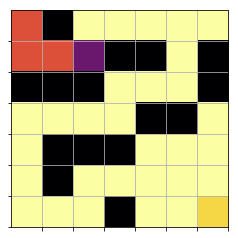

In [58]:
SEQUENCE = [DOWN, DOWN, RIGHT, RIGHT, RIGHT, UP]
SEQUENCE_LONG = [DOWN, DOWN, RIGHT, RIGHT, RIGHT, 
                 UP, RIGHT, UP, RIGHT, RIGHT, 
                 DOWN, RIGHT, DOWN, DOWN, LEFT, 
                 LEFT, LEFT, DOWN, DOWN, DOWN, 
                 RIGHT, RIGHT, DOWN, RIGHT]
SEQUENCE_INTO_WALL = [DOWN, DOWN, DOWN, DOWN, 
                      RIGHT, RIGHT, RIGHT, RIGHT, RIGHT]
qmaze.reset(rat=(0,0))

for seqnum, seq in enumerate(SEQUENCE_INTO_WALL):
    qmaze.act(seq)
    show(qmaze, cmap_input='inferno');
    
    filler_str = ''
    if seqnum < 10:
        filler_str = '0'
        
    plt.savefig(folder_name_pngs + '/' + filler_str + str(seqnum) + '.png')

In [59]:
filenames_pngs = os.listdir(folder_name_pngs)

In [60]:
images = []
for filename in filenames_pngs:
    images.append(imageio.imread(folder_name_pngs + '/' + filename))
imageio.mimsave(folder_name_gif + '/seq_movie.gif', images, duration = 0.01)


- **n_epoch** - Number of training epochs  
- **max_memory** - Maximum number of game experiences we keep in memory (see the Experince class above)  
- **data_size** - Number of samples we use in each training epoch. This is the number episodes (or game experiences) which we randomly select from our experiences repository (again, see the Experience class above)


In [61]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU

def build_model(maze, lr=0.001):
    """Keras Model"""
    # TODO: make sure, "maze" input is correct (array has correct format)
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [120]:
# Exploration factor
epsilon = 0.1

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)
    
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True



def play_game(model, qmaze, rat_cell):
    """plays until win or lose"""
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False


        
        
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()
    
    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)
    
    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1
    
    print('number of epochs= ', n_epoch)
    for epoch in range(n_epoch):
        # temp - print('epoch=', epoch, '  --  out of n_epoch=', n_epoch)
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas/maze)
        # observe(): makes sure, you only have maze + rat (without path)
        #            and then flattens the maze
        envstate = qmaze.observe()
        # temp - print('starting envstate=', envstate, 'Starting Games\n')

        n_episodes = 0
        while not game_over:
            # temp - print('...move/episode=', n_episodes)
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break  # if list of "valid_actions" is empty: break
            prev_envstate = envstate
            
            # Get next action
            if np.random.rand() < epsilon:
                # temp - print('...action chosen at random')
                action = random.choice(valid_actions)
            else:
                # temp - print('...action chosen according to model.predict (argmax)')
                # temp - print('...experience.prediction(prev_envstate)=', experience.predict(prev_envstate))
                action = np.argmax(experience.predict(prev_envstate))  # model.predict()
                
            # Apply action, get reward and new envstate
            #    output of act:
            #      envstate: flattened maze + rat (without rat's path)
            #      reward: reward of this particular move
            #      status: new game status (3 possibilities: lose, win, not_over)   
            # temp - print('...now acting')
            envstate, reward, game_status = qmaze.act(action)
            # temp - print('...valid actions=', valid_actions, ' -- action=', action, '/',actions_dict[action], 
            # temp -       '  -- new state=', qmaze.state)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False
                
            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            # experience.remember():  self.memory.append(episode)
            experience.remember(episode)   
            n_episodes += 1
            
            # Train neural network model
            # temp - print('... ...checking prediction: ')
            # temp - print('...prediction on prev_envstate=', experience.predict(prev_envstate))
            # temp - print('...prediction on envstate=     ', experience.predict(envstate))
            inputs, targets = experience.get_data(data_size=data_size)
            # input= envstate at random
            # target= reward + gamma * max_a' Q(s', a')
            #      reward= 
            #               1     - rat found cheese
            #               -33   - mode==blocked ((-0.5 * 8 * 8) - 1 <-- example maze 8*8)
            #                       (self.min_reward = -0.5 * self.maze.size)
            #               -0.25 - cell already visited
            #               -0.75 - mode==invalid (no change in position)
            #               -0.04 - mode==valid
            #      gamma= 0.95
            #      max_a' Q(s', a')=  np.max(self.predict(envstate_next))
            # temp -- print('...inputs=', inputs)
            # temp -- print('...inputs.size=',inputs.size)
            # temp - print('...inputs - how many envstates=', inputs.__len__(), '  --  each with ', inputs[0].__len__(), ' elements')
            # temp - print('...targets=', targets)
            
            # temp - print('starting model.fit')
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=2)
            
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05   # Exploration factor
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

        # temp - print('\n')
        # if n_episodes==19:
        #     sys.exit()
                
                
    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('\n\nfiles: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

In [121]:
num_actions = len(actions_dict)

maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
# show(qmaze)
model = build_model(maze)
# print(model.summary())

# experience = Experience(model, max_memory=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 49)                2450      
_________________________________________________________________
p_re_lu_41 (PReLU)           (None, 49)                49        
_________________________________________________________________
dense_62 (Dense)             (None, 49)                2450      
_________________________________________________________________
p_re_lu_42 (PReLU)           (None, 49)                49        
_________________________________________________________________
dense_63 (Dense)             (None, 4)                 200       
Total params: 5,198
Trainable params: 5,198
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
# default settings:
# n_epoch=15'000 | max_memory=1000 | data_size=50
qtrain(model=model, maze=maze, n_epoch=1000, max_memory=8*maze.size, data_size=32)

number of epochs=  1000
Epoch: 000/999 | Loss: 0.0018 | Episodes: 105 | Win count: 0 | Win rate: 0.000 | time: 7.6 seconds
Epoch: 001/999 | Loss: 0.0017 | Episodes: 109 | Win count: 0 | Win rate: 0.000 | time: 13.0 seconds
Epoch: 002/999 | Loss: 0.0027 | Episodes: 110 | Win count: 0 | Win rate: 0.000 | time: 18.7 seconds
Epoch: 003/999 | Loss: 0.0017 | Episodes: 103 | Win count: 0 | Win rate: 0.000 | time: 23.7 seconds
Epoch: 004/999 | Loss: 0.0382 | Episodes: 109 | Win count: 0 | Win rate: 0.000 | time: 29.0 seconds
Epoch: 005/999 | Loss: 0.0017 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 33.9 seconds
Epoch: 006/999 | Loss: 0.0422 | Episodes: 89 | Win count: 1 | Win rate: 0.000 | time: 38.2 seconds
Epoch: 007/999 | Loss: 0.0030 | Episodes: 109 | Win count: 1 | Win rate: 0.000 | time: 43.6 seconds
Epoch: 008/999 | Loss: 0.0045 | Episodes: 62 | Win count: 2 | Win rate: 0.000 | time: 47.0 seconds
Epoch: 009/999 | Loss: 0.0278 | Episodes: 101 | Win count: 2 | Win rate: 0.000 

278.477652

In [123]:
qmaze_result = Qmaze(maze)

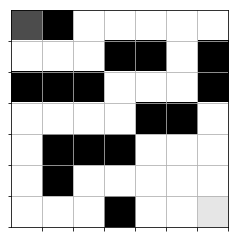

In [124]:
show(qmaze_result);

In [125]:
pred = model.predict(maze.reshape(1,-1))
pred

array([[-0.02604586, -0.17031717,  0.00070082, -0.3416536 ]],
      dtype=float32)

In [126]:
pred_argmax = np.argmax(pred)  # Returns the indices of the maximum values along an axis.
pred_argmax

2

In [127]:
actions_dict[pred_argmax]

'right'

In [113]:
qmaze_result.act(pred_argmax)

(array([[0.5, 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 1. ,
         0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. ,
         0. , 1. , 1. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0. , 1. , 1. ,
         1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. ]]),
 -0.25,
 'not_over')

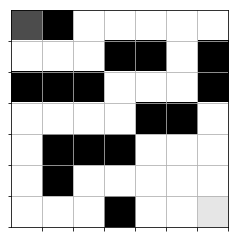

In [115]:
show(qmaze_result);

In [130]:
play_game(model=model, qmaze=Qmaze(maze), rat_cell=(1,0))

True